In [1]:
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.feature_extraction.text import TfidfVectorizer

DOCUMENTS_JSON = 'data/BrowsingHistoryWordbags.json'


In [2]:
df = pd.read_json(DOCUMENTS_JSON)

In [3]:
df_trim = df[df.response_code == 200].copy()

In [4]:
df_trim['url'].value_counts()

https://www.kaggle.com/learn                                                                                                                                                                           26
https://www.youtube.com/                                                                                                                                                                               25
https://www.linkedin.com/my-items/saved-jobs/                                                                                                                                                          11
https://www.linkedin.com/feed/                                                                                                                                                                         11
https://en.wikipedia.org/wiki/Monte_Carlo_method                                                                                                                                                

In [5]:
corpus = [row.wordbag for _,row in df_trim.iterrows()]

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
feature_matrix = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out()[-50:])
print(feature_matrix.shape)

In [ ]:
clust = OPTICS(min_samples=50, xi=0.07, min_cluster_size=0.05)
X = feature_matrix.toarray()
clust.fit(X)

In [ ]:
vectorizer2 = TfidfVectorizer(sublinear_tf=True)
feature_matrix2 = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names_out()[:50])
print(feature_matrix2.shape)

In [ ]:
clust2 = OPTICS(min_samples=50, xi=0.01, min_cluster_size=0.05)
X2 = feature_matrix2.toarray()
clust2.fit(X2)

In [12]:
vectorizer3 = TfidfVectorizer(sublinear_tf=True, max_df=0.8, min_df=0.04)
feature_matrix3 = vectorizer3.fit_transform(corpus)
print(vectorizer3.get_feature_names_out())
print(feature_matrix3.shape)

['abl' 'accept' 'access' 'accord' 'account' 'activ' 'actual' 'ad' 'adapt'
 'add' 'addit' 'address' 'adresu' 'advertis' 'affect' 'afrikaans' 'ago'
 'agre' 'agreement' 'aktualnie' 'aktywność' 'al' 'algorithm' 'allow'
 'alreadi' 'also' 'altern' 'alway' 'analysi' 'analyt' 'anoth' 'answer'
 'anyth' 'appear' 'appli' 'applic' 'approach' 'approxim' 'arab' 'area'
 'argument' 'around' 'array' 'art' 'articl' 'ask' 'assign' 'associ'
 'assum' 'attribut' 'automat' 'autorski' 'avail' 'averag' 'avoid'
 'azərbaycan' 'back' 'badg' 'bahasa' 'base' 'basic' 'bayesian' 'becom'
 'begin' 'behavior' 'best' 'better' 'bezpieczeństwo' 'blog' 'book'
 'bosanski' 'box' 'brand' 'brasil' 'bronz' 'brows' 'build' 'busi' 'być'
 'calcul' 'call' 'cambridg' 'canada' 'cannot' 'career' 'carlo' 'case'
 'català' 'categori' 'caus' 'cel' 'cela' 'center' 'central' 'centrum'
 'certain' 'chain' 'chang' 'chapter' 'charact' 'chart' 'chat' 'chcieć'
 'check' 'chines' 'choic' 'choos' 'chwila' 'citat' 'cite' 'clarif' 'class'
 'claus' 'cli

In [21]:
clust3 = OPTICS(min_samples=20, xi=0.02, min_cluster_size=0.05)
X3 = feature_matrix3.toarray()
clust3.fit(X3)

C:\JupyterLab\resources\jlab_server\lib\site-packages\sklearn\cluster\_optics.py:904: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(min_cluster_size=0.05, min_samples=20, xi=0.02)

Text(0.5, 1.0, 'Automatic Clustering\nOPTICS')

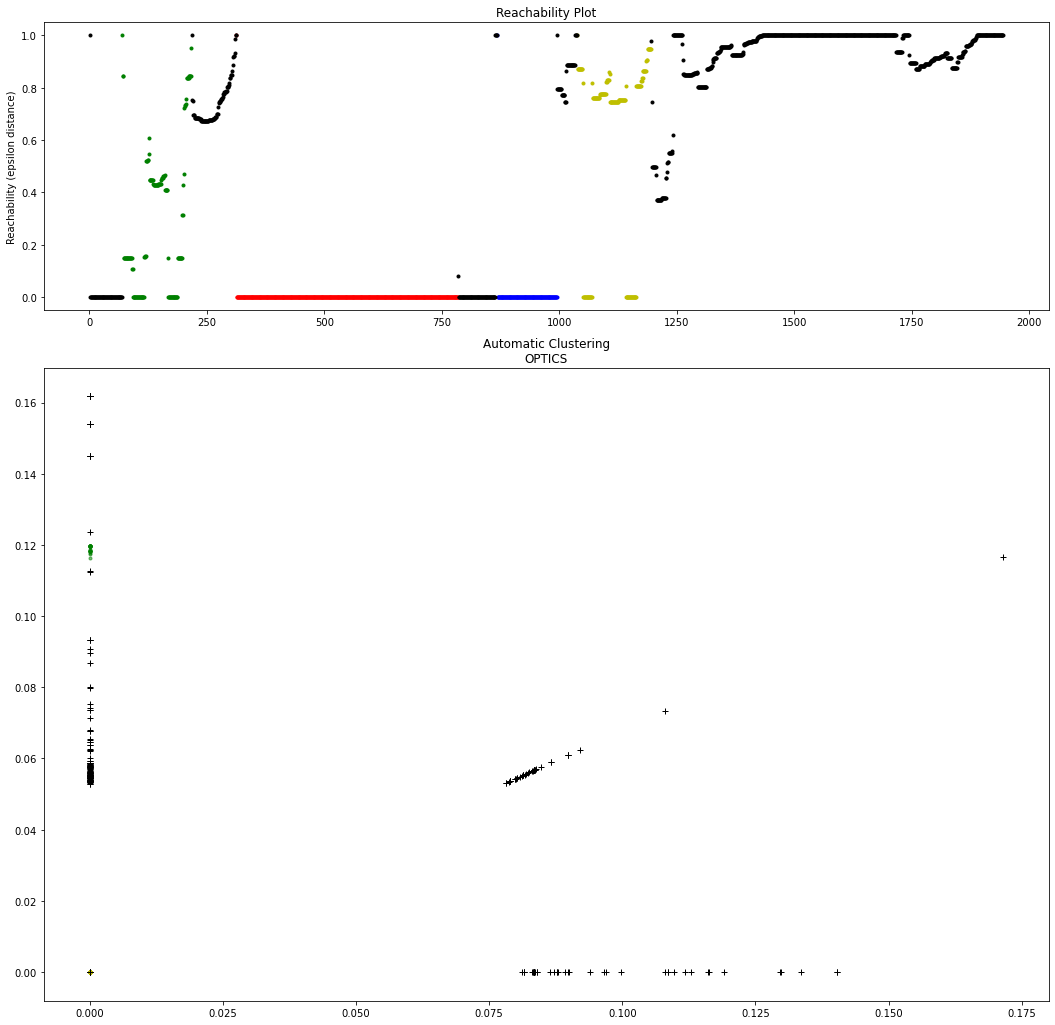

In [56]:
space = np.arange(X3.shape[0])
reachability = clust3.reachability_[clust3.ordering_]
labels = clust3.labels_[clust3.ordering_]

plt.figure(figsize=(18, 18))
G = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1:3, :])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "m."]
for klass, color in zip(range(0, max(clust3.labels_)+1), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=1)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=1)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "m."]
for klass, color in zip(range(0, max(clust3.labels_)+1), colors):
    Xk = X3[clust3.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 24], color, alpha=0.3)
ax2.plot(X3[clust3.labels_ == -1, 0], X3[clust3.labels_ == -1, 1], "k+", alpha=1)
ax2.set_title("Automatic Clustering\nOPTICS")

In [53]:
max(clust3.labels_)

3

In [ ]:
Xk

3

In [ ]:
reachability